In [8]:
import SimDAT2D as sim
import numpy as np
import numpy.ma as ma
import numpy.random as rnd
import matplotlib.pyplot as plt
import pyFAI
import pyFAI.azimuthalIntegrator as AI
import os
import pandas as pd
import dask
from dask import delayed
from scipy.ndimage import rotate as scipy_rotate

In [2]:
def slice_mask(chi, width, plot = False):
    ''' Returns a mask that has one slice of the chi array left unmasked to be used for integration.

    Keyword arguments:
    chi -- chi array 
    width -- width of the slice in degrees
    plot -- if True, plots the mask (default False)
    '''
    #creating the mask and setting the first width pixels to False to leave a slice of width pixels unmasked
    mask = np.ma.masked_outside(chi, 0, width)
    
    if plot == True:
        plt.figure()
        plt.imshow(mask, cmap='magma')
    
    return mask

In [3]:
def make_chi_array(tiff, dist, wavelength):
    ''' Returns a chi array from a tiff file.
    
    Keyword arguments:
    tiff -- tiff file
    dist -- distance from the sample to the detector
    wavelength -- wavelength of the x-rays
    '''
    
    #creating the detector object and calculating the cartesian positions
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    #creating the azimuthal integrator object
    ai_pe = AI.AzimuthalIntegrator(dist=dist, wavelength=wavelength, poni1=poni1, poni2=poni2, detector=dete)
    
    #creating the chi array
    chi_array = np.degrees(ai_pe.chiArray())
    
    return chi_array, ai_pe

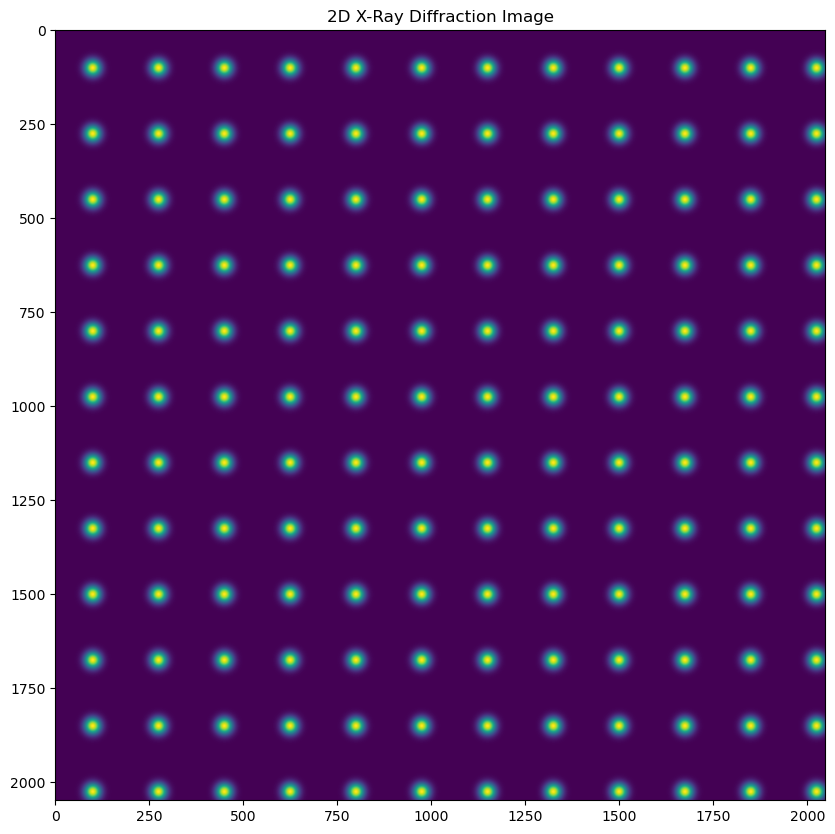

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
Au


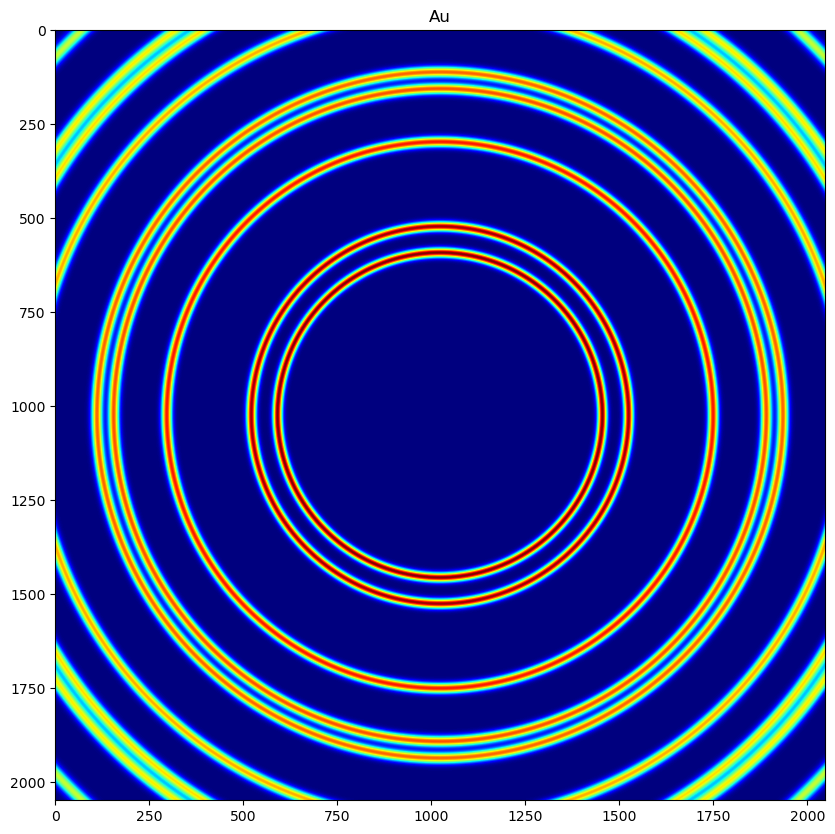

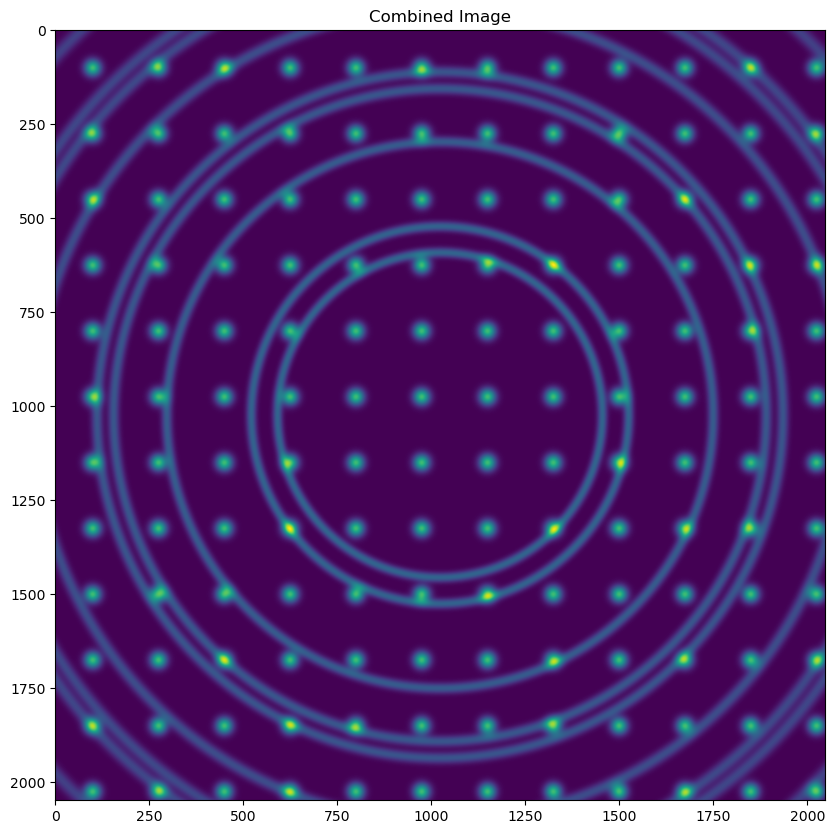

In [4]:
my_tiff = sim.combine_image((sim.create_anisotropic(25, 15, 175, size = 200)*2), sim.create_isotropic(.4, .5e-10, cmap = 'jet'))

In [10]:
chi_array, ai_pe = make_chi_array(my_tiff, 0.4, 0.5e-10)

In [11]:
chi_array.max()

179.9719970540696

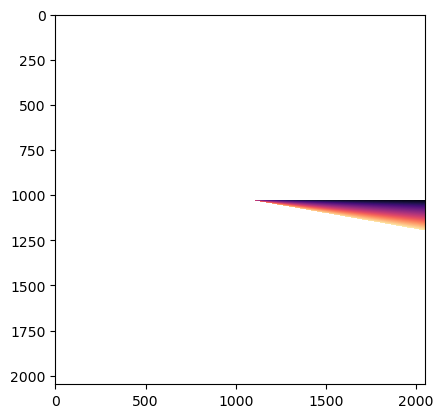

In [32]:
my_mask = slice_mask(chi_array, 10, plot = True)

In [13]:
def rotate_mask_360(chi_array, width, rot_degree = 1, plot = False):
    ''' Rotates a mask 360 degrees around the center of the mask.
    
    Keyword arguments:
    mask -- mask to be rotated
    chi_array -- chi array to be used for the rotation
    '''
    #creating a list of angles to rotate the mask
    
    positive_angles = np.arange(0, 179, rot_degree)
    negative_angles = np.arange(-179, 0, rot_degree)
    
    #creating a list of rotated masks
    rotated_masks = []
    
    #rotating the mask and appending it to the list of rotated masks
    for angle in positive_angles:
        rotated_masks.append(np.ma.masked_outside(chi_array,0+angle, width+angle))
        
        if plot == True:
            plt.figure()
            plt.imshow(rotated_masks[-1], cmap = 'magma')
        
    for angle in negative_angles:
        rotated_masks.append(np.ma.masked_outside(chi_array,0+angle, width+angle))
        
        if plot == True:
            plt.figure()
            plt.imshow(rotated_masks[-1], cmap = 'magma')
    
    return rotated_masks

In [ ]:
#rotated_masks = rotate_mask_360(chi_array, .5, rot_degree = .9)

In [ ]:
#len(rotated_masks)

In [ ]:
# def multiple_slice_mask(array, width, num, offset = 30, plot = False):
#     ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.
    
#     Keyword arguments:
#     chi_array -- chi array 
#     width -- width of the slice in degrees
#     num -- number of slices
#     plot -- if True, plots the masks (default False)
#     '''
    
#     mask = ma.masked_all_like(chi_array)
    
#     # Create masks for the positive values
#     for i in range(num):
#         start = i * (width + offset)
#         end = start + width
#         mask = ma.masked_outside(array, start, end, copy=False)

#     # Create masks for the negative values
#     for i in range(num):
#         start = - (i + 1) * (width + offset)
#         end = start - width
#         mask = ma.masked_outside(array, start, end, copy=False)
    
#     #add all genrated masks together
#     if plot == True:
#         plt.figure()
#         plt.imshow(mask, cmap='magma')
    
#     return mask

In [ ]:
multiple_slice_mask(chi_array, 5, 5, plot = True)

In [ ]:
#Using masked array in numpy, I need to create multiple unmasked slices of my chi array
#These unmaksed slices needs to be in a masked array. This will should look like a pin wheel of unmasked slices
#The unmaksed slices are going to be user defined in their width of degrees and the number of slices desired
#this function will then return the masked array of the unmasked slices using this information. This should
#not be like any of the other functions that I have created. It should be a new function that uses the
#masked array function in numpy.

def make_mask_slices(width, num_slices, chi_array, plot = False):
    ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.

        keyword arguments:
        width -- width of the slice in degrees
        num_slices -- number of slices
        chi_array -- chi array to be used for the mask
        plot -- if True, plots the mask (default False)
        ''' 
        #creating the mask and setting the first width pixels to False to leave a slice of width pixels unmasked
        mask = np.ma.masked_all_like(chi_array)
        

In [ ]:
mask = ma.masked_all_like(chi_array)

# Create masks for the positive values
i = 5
if i == 5:
    num = range(i)
    start1 = num[0] * (20 + 30)
    end1 = start + 20
    start2 = num[1] * (20 + 30)
    end2 = start2 + 20
    start3 = num[2] * (20 + 30)
    end3 = start3 + 20
    start4 = num[3] * (20 + 30)
    end4 = start4 + 20
    start5 = num[4] * (20 + 30)
    end5 = start5 + 20
    
    mask = ma.masked_outside(chi_array, start, end, copy = False)
    mask = ma.masked_outside(chi_array, start2, end2, copy = False)
    mask = ma.masked_outside(chi_array, start3, end3, copy = False)
    mask = ma.masked_outside(chi_array, start4, end4, copy = False)
    mask = ma.masked_outside(chi_array, start5, end5, copy = False)

In [ ]:
if False in mask.mask:
    print('False')

In [ ]:
plt.figure()
plt.imshow(mask, cmap='magma')

In [ ]:
combined = mask_list[0] + mask_list[4]

In [ ]:
plt.figure()
plt.imshow(mask_list[0])

In [ ]:
print(*mask_list[1].mask)

In [ ]:
import numpy.ma as ma

# Assuming chi_array is your array containing values from 0 to 180 and -180 to 0
# Create an initial mask with all True values (completely masked)
combined_mask = ma.masked_all_like(chi_array)

# Define parameters for slices
slice_width = 5
offset_between_slices = 30
num_slices = 5

combined_mask = ma.masked_outside(chi_array, 0, 5, copy=False)
combined_mask = ma.masked_outside(chi_array, 30, 35, copy=False)
#combined_mask = ma.masked_outside(chi_array, 60, 65, copy=False)
# Create slices in the mask
#for i in range(num_slices):
 #   start = i * (slice_width + offset_between_slices)
  #  end = start + slice_width
   # combined_mask = ma.masked_inside(chi_array, start, end, copy=False)

# The combined_mask now contains multiple unmasked slices

In [ ]:
plt.figure()
plt.imshow(combined_mask)

In [ ]:
print(*combined_mask.mask)

In [14]:
def generate_mask_slices(array, width, num_slices, offset = 5):
    
    ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.
    
    Keyword arguments:
    chi_array -- chi array
    width -- width of the slice in degrees
    num_slices -- number of slices
    offset -- offset between slices in degrees
    plot -- if True, plots the mask (default False)
    
    '''
    mask_list = []
    
    # Create masks for the positive values
    for i in range(num_slices):
        start = i * (width + offset)
        end = start + width
        mask_list.append(ma.masked_inside(array, start, end))

    # Create masks for the negative values
    for i in range(num_slices):
        start = - (i + 1) * (width + offset)
        end = start - width
        mask_list.append(ma.masked_inside(array, start, end))
    
    #add all genrated masks together
    
    print(mask_list)

    combined_mask = mask_list[0]
    for mask in mask_list[1:]:
        combined_mask += mask
        
    inverted_mask = ~combined_mask.mask 
    plt.figure()
    plt.imshow(~combined_mask.mask)
    
    return inverted_mask

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

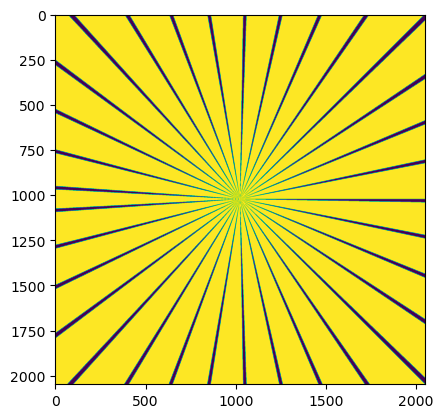

In [15]:
t = generate_mask_slices(chi_array, 1, 20, offset = 10)

In [22]:
len(t)

2048

In [21]:
t.sum()

4148351

In [ ]:
dete = pyFAI.detectors.Perkin()
p1, p2, p3 = dete.calc_cartesian_positions()
poni1 = p1.mean()
poni2 = p2.mean()
    

ai_pe = AI.AzimuthalIntegrator(dist=0.4, wavelength=.5e-10, poni1=poni1, poni2=poni2, detector=dete)

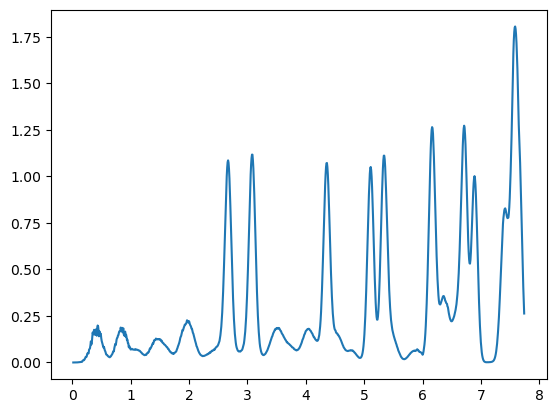

In [16]:
integration = ai_pe.integrate1d(my_tiff, 1000, mask = t, unit = 'q_A^-1')

plt.figure()
plt.plot(integration[0], integration[1])

In [ ]:
integration = ai_pe.integrate1d(my_tiff, 1000, mask = combined_mask, unit = 'q_A^-1')

plt.figure()
plt.plot(integration[0], integration[1])

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

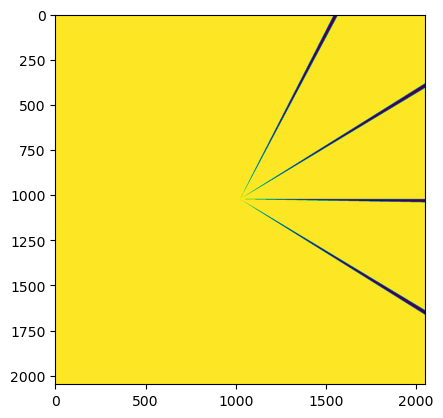

In [18]:
t = generate_mask_slices(chi_array, 1, 2, offset = 30)

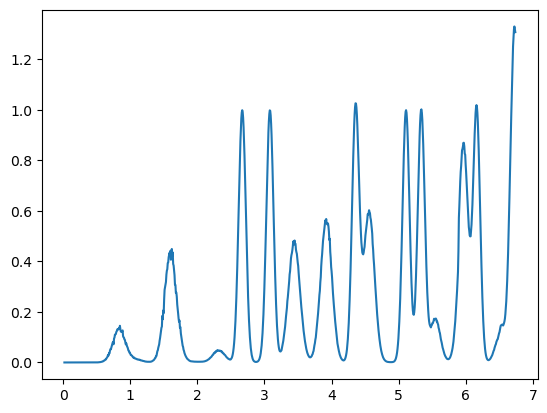

In [19]:
integration = ai_pe.integrate1d(my_tiff, 1000, mask = t, unit = 'q_A^-1')

plt.figure()
plt.plot(integration[0], integration[1])

In [20]:
t.sum()

4148351

In [23]:
def rotate_generated_mask(mask, deg, offset = 1, plot = False):
    rotated_masks = []
    deg_list = np.arange(0, deg, offset)  # Adjust the range as needed
    for i in deg_list:
        rotated_mask = ma.masked_invalid(scipy_rotate(mask, angle=i, reshape=False, order=0))
        rotated_masks.append(rotated_mask)
        if plot == True:  
         plt.figure()
        
         plt.imshow(rotated_mask)
    return rotated_masks

[masked_array(
   data=[[True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         ...,
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True],
         [True, True, True, ..., True, True, True]],
   mask=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
   fill_value=True),
 masked_array(
   data=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [Fal

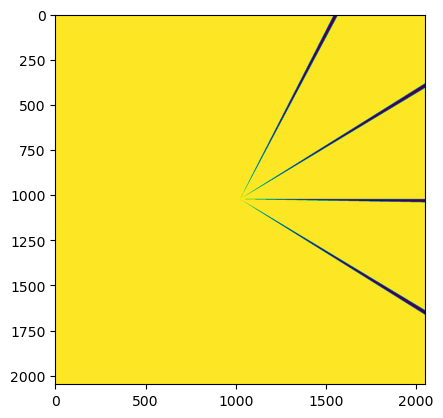

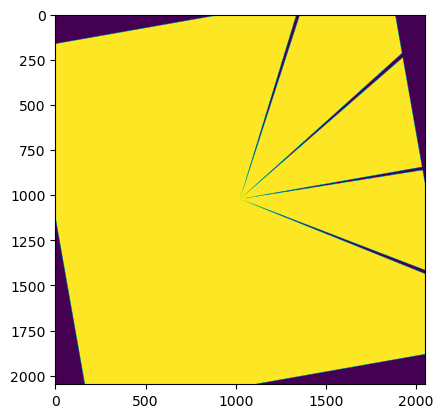

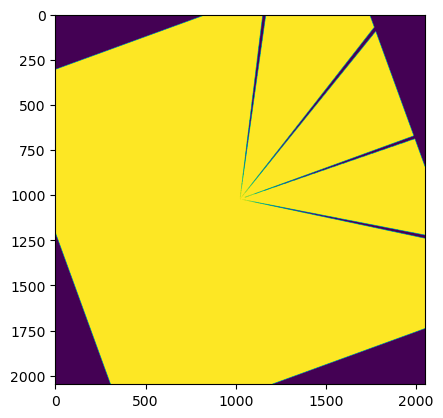

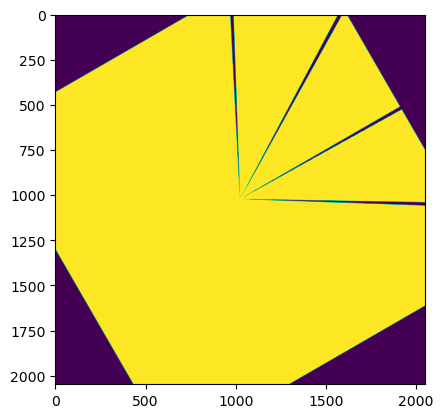

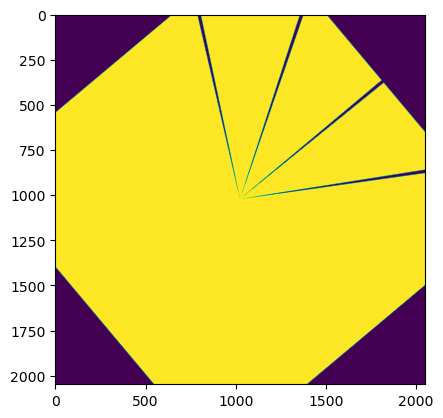

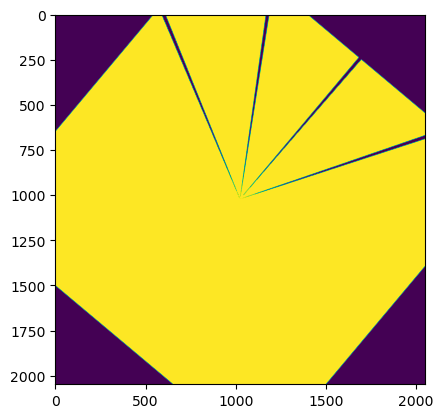

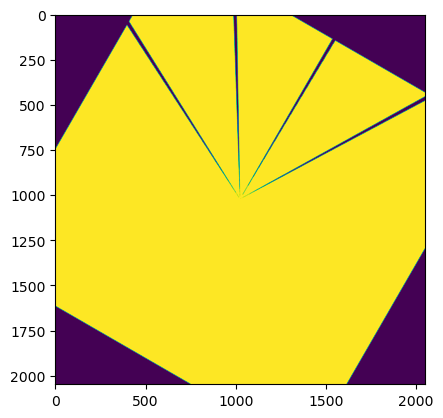

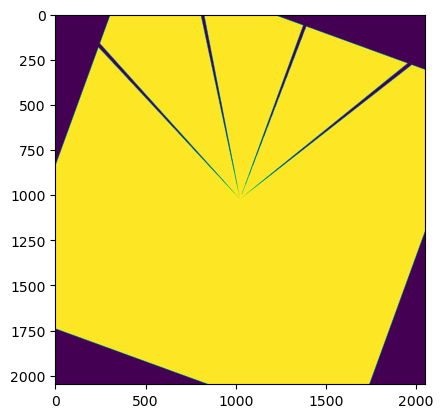

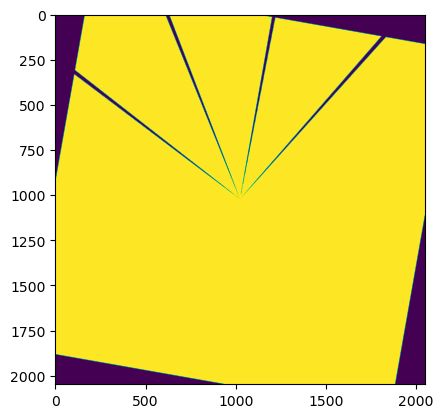

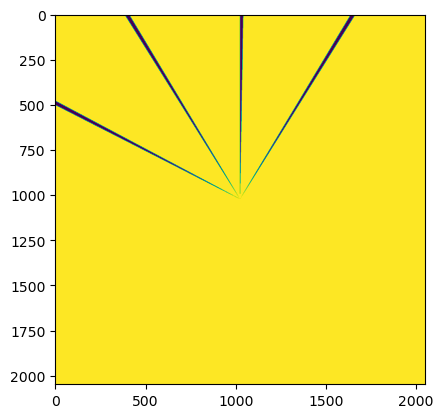

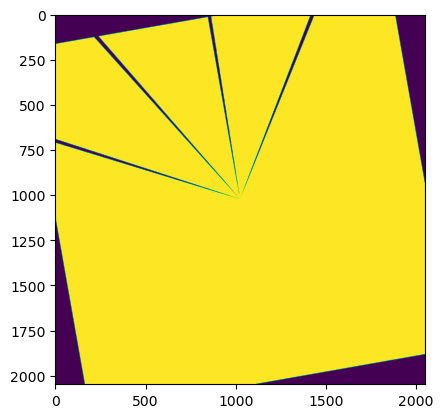

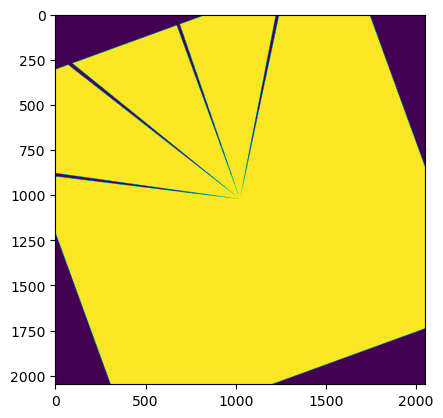

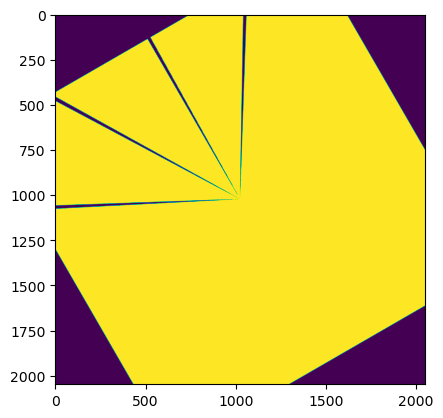

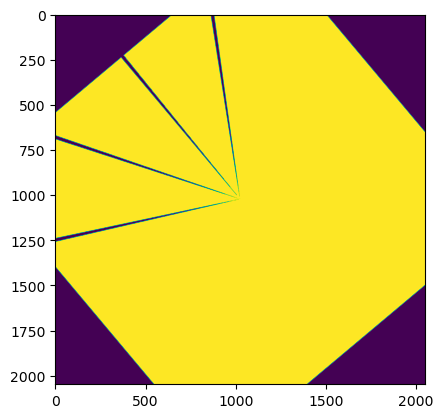

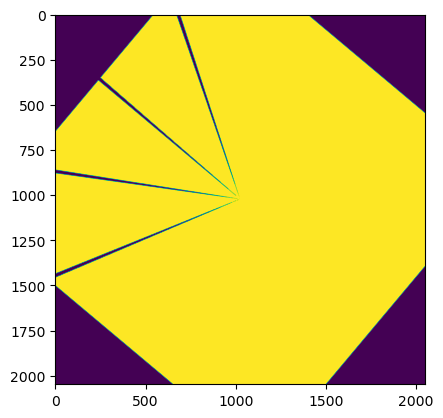

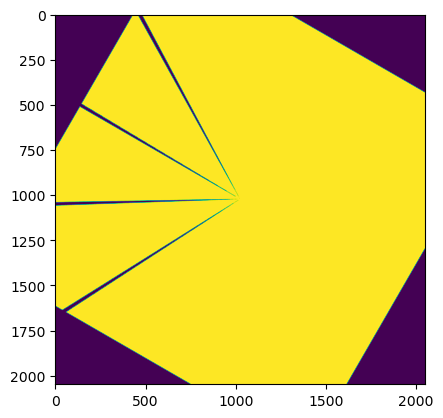

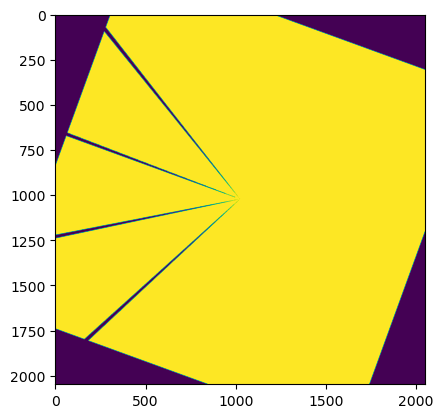

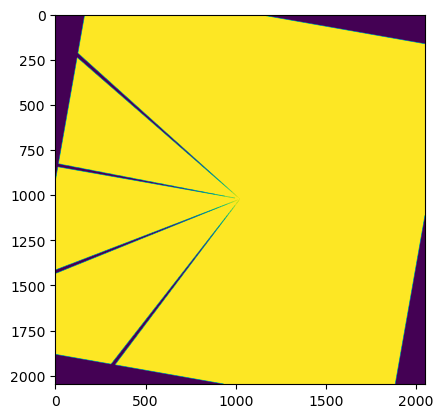

In [24]:
rotate_generated_mask(t, 180, 10, plot = True)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def make_colormap(length, use_cmap='plasma'):
    cmap = plt.get_cmap(use_cmap)
    colors = cmap(np.linspace(0, 1, length))
    return colors.tolist()

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

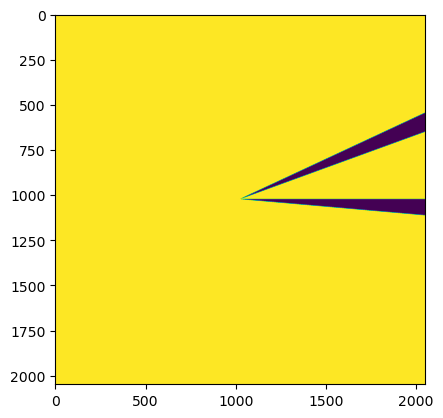

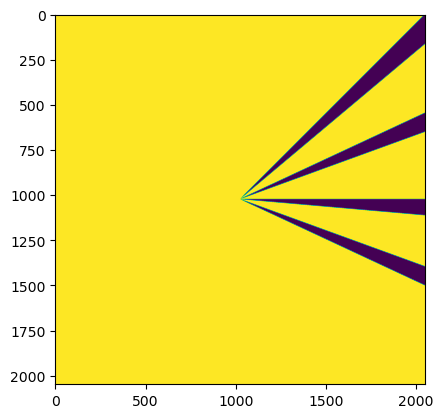

In [26]:
masks_for_interact = []

for i in range(2):
    mask_for_rotate = generate_mask_slices(chi_array, 5, i+1, offset = 15)
    to_append = rotate_generated_mask(mask_for_rotate, 360, offset = 1, plot = False)
    masks_for_interact.append(to_append)

In [27]:
import itertools
merged = list(itertools.chain(*masks_for_interact))

In [28]:
len(merged)

720

In [31]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

I_list = np.arange(0, 720, 1)
cc = make_colormap(len(I_list)+10,use_cmap='plasma')

def f(i):
    phi_list = np.arange(0, np.pi,.05)
    plt.subplot(121)
    plt.cla()

    plt.plot(ai_pe.integrate1d(my_tiff, 1000, unit = 'q_A^-1', mask = merged[I_list[i]])[0], ai_pe.integrate1d(my_tiff, 1000, unit = 'q_A^-1', mask = merged[I_list[i]])[1], color = cc[i])
    #plt.plot(q, I_list[i],c=cc[i],label=round(phi_list[i],3))
    #plt.legend(loc=0)

    plt.subplot(122)
    plt.cla()

    plt.imshow(merged[i]+my_tiff)
    
    plt.show()

plt.figure()

interact(f, i=widgets.IntSlider(min=0, max=len(I_list)-1, step=1, value=720));

<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=719, description='i', max=719), Output()), _dom_classes=('widget-interac…

In [ ]:
#The mask generation is taking up too much memory, I need to integrate and then delete the mask 
#all in the same program and return only the integrations. I need to use parallisim through dask.delayed
#to make this work. I need to create a function that will take in the chi array, the width of the slices,
#the number of slices, and the offset between slices. This function will then return the integration of the
#tiff file using the generated mask. 

def rotate_and_integrate(tiff, width, num_slices = 1, num_rotations = 360, offset = 5, plot = False, randomize = False):
    
    ''' Returns the rotation integrations of a tiff file using masking.

        Keyword arguments:
        tiff -- tiff file to be integrated
        width -- width of the slice in degrees
        num_slices -- number of slices (default 1)
        num_rotations -- number of rotations (default 360)
        offset -- offset between slices in degrees (default 5)
        plot -- if True, plots the mask (default False)
        '''
    